In [2]:
import numpy as np
from numpy import array
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import CEEMDAN
from PyEMD import EMD
from PyEMD import EEMD
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
# from tqdm import tqdm
from numpy import hstack
tf.random.set_seed(10.0)

N_STEPS =  7 #用多少天/周预测一天/周
N_FEATURES = 1 #用来预测的总变量数，如果同时适用销量和定价来预测销量的话这里改成2，以此类推
PRED_DAYS = 7 #预测多少天

In [4]:
# 用来分割原数据集使得数据集变成能训练的形状
def splitSequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [5]:
#读数据集，tableName是数据集的文件名，columnName是数据集的列名
def readData(tableName,columnName):
    date_read = pd.read_csv(tableName)
    dataset = date_read[columnName].values
    dataset = dataset.astype('float32')
    maxValue = np.max(dataset)  # 获得最大值
    minValue = np.min(dataset)
    scalar = maxValue - minValue  # 获得间隔数量
    #dataset = list(map(lambda x: (x - minValue) / scalar, dataset))
    return dataset

In [6]:
#归一化数据
def normalizeData(dataset):
    maxValue = np.max(dataset)  # 获得最大值
    minValue = np.min(dataset)
    scalar = maxValue - minValue  # 获得间隔数量
    dataset = list(map(lambda x: (x - minValue) / scalar, dataset))
    return dataset, scalar, minValue

In [7]:
#对总数据集进行分割，获取训练集X_train，y_train，预测集X_test，y_test
#预测集不会放入模型中训练，是用训练好的模型输入X_test得到结果来和y_test比较
def getTrainAndTest(dataset):
    X_all, y_all = splitSequence(dataset, N_STEPS)
    X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], N_FEATURES))
    # 这个常数需要自行修改，根据下面的代码可以知道，这个常数是将总数据集进行分割。分割后的效果应该是X_test的长度正好是之前定义的预测的天数
    # 然而由于本人数学能力有限，并未写成计算公式，而本人在使用过程中也是自己乱凑的常数
    # 如果在训练过程中发现“。。。。can not put into the shape (。。。)”之类的报错，多半是这个常数设错了
    train_size = len(y_all) - PRED_DAYS
    print(train_size)
    test_size = len(X_all) - train_size

    # Check the size of test data
    # 好像check出来也不一定对，不去管它
    print(test_size)
    
    X_train = X_all[:train_size]
    y_train = y_all[:train_size]
    X_test = X_all[train_size:]
    y_test = y_all[train_size:]

    return X_train, y_train, X_test, y_test

In [8]:
# 用TensorFlow实现的LSTM模块，输入训练集X_train，y_train进行训练，输入X_test进行预测
# 输出预测结果yhat
# reference: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
def trainAndPred(X_train, y_train, X_test):
    modelDouble = Sequential()
    # 这里使用了bidirectional，其实改成单向也可以
    modelDouble.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(N_STEPS, N_FEATURES)))
    # modelDouble.add(LSTM(50, activation='relu', input_shape=(N_STEPS, N_FEATURES)))
    modelDouble.add(Dense(1))
    modelDouble.compile(optimizer='adam', loss='mse')
    # 这里使用了callback机制防止过拟合，实践证明效果很好
    callback = EarlyStopping(monitor='loss', patience=10)
    # modelDouble.fit(X_train, y_train, epochs=500, verbose=0, callbacks=[callback], batch_size=5)
    modelDouble.fit(X_train, y_train, epochs=1500, verbose=0, callbacks=[callback], batch_size=5)
    x_input = X_test

    # Check the size of test data
    print(x_input.shape)
    
    x_input = x_input.reshape((PRED_DAYS, N_STEPS, N_FEATURES))
    yhat = modelDouble.predict(x_input, verbose=0)
    return yhat

In [9]:
# 将此前归一化的数据反归一化
# 由于出现了bug，暂时不考虑使用归一化
def returnNormal(scalar, minValue, y_hat, y_test):
    pred_y = list(map(lambda x: x * scalar + minValue, y_hat))
    real_y = list(map(lambda x: x * scalar + minValue, y_test))
    return pred_y, real_y

In [10]:
# 搞的基于EMD算法的LSTM
# 具体原理：https://www.hindawi.com/journals/complexity/2020/6431712/
def emdLSTM(dataset):
    # ceemdan = EEMD()
    ceemdan = EMD()
    IMFs = ceemdan.emd(dataset)
    print(type(IMFs))
    [rows, columns] = IMFs.shape
    yhatResult = 0
    # yhatResult = np.zeros((PRED_DAYS,1))
    for n, imf in enumerate(IMFs):
        tempDataSet = imf
        #print('--------------------------------------')
        # myDataSet, myScalar, myMinValue = normalizeData(tempDataSet)
        X_train, y_train, X_test, y_test = getTrainAndTest(tempDataSet)
        pred_y = trainAndPred(X_train, y_train, X_test)
        # pred_y, _ = returnNormal(myScalar, myMinValue, yhat, y_test)
        # print(pred_y)
        yhatResult = pred_y + yhatResult
    print(yhatResult)
    return yhatResult

In [11]:
# 一些判断模型的评判标准
def metrics(test,predict):
    print( 'MSE均方误差,越小越好')
    mse = mean_squared_error(test, predict)
    print("MSE=", mse)

    print( 'MAE数值越小越好，可以通过对比判断好坏')
    mae = mean_absolute_error(test, predict)
    print("MAE=", mae)

    print( 'R平方值，越接近1越好')
    r2 = r2_score(test, predict)
    print("R_square=", r2)
    
    accu_all = 0
    for i in range(len(predict)):
        if int(test[i]) == 0:
            continue
        accu = abs(test[i]-predict[i])/test[i]
        accu_all += accu
    accu_avg = accu_all/len(predict)*100
    print('平均误差为' + str(accu_avg) + '%')

In [12]:
# 读数据
dataset = readData('Nansha_Yingkou_after_add.csv', 'NUM_BOX')
dataset.shape
#print(dataset_together)

(181,)

In [13]:
# 获得训练集预测集 
#dataset, scalar, minValue = normalizeData(dataset)
X_train, y_train, X_test, y_test = getTrainAndTest(dataset)
print(y_test)

167
7
[1. 1. 3. 7. 3. 1. 1.]


In [14]:
yhat = emdLSTM(dataset) #使用EMD-LSTM用这一行
#yhat = trainAndPred(X_train, y_train, X_test) #使用一般LSTM用这一行
#y_pred = returnNormal(scalar, minValue, yhat, y_test)
print(yhat)

<class 'numpy.ndarray'>
167
7
(7, 7, 1)
167
7
(7, 7, 1)
167
7
(7, 7, 1)
167
7
(7, 7, 1)
167
7
(7, 7, 1)
167
7
(7, 7, 1)
167
7
(7, 7, 1)
[[1.5359497]
 [2.6444404]
 [3.0082319]
 [4.363965 ]
 [2.947407 ]
 [2.8779464]
 [2.5472906]]
[[1.5359497]
 [2.6444404]
 [3.0082319]
 [4.363965 ]
 [2.947407 ]
 [2.8779464]
 [2.5472906]]


MSE均方误差,越小越好
MSE= 2.2662473
MAE数值越小越好，可以通过对比判断好坏
MAE= 1.1860695
R平方值，越接近1越好
R_square= 0.46612438480491336
平均误差为[85.749695]%


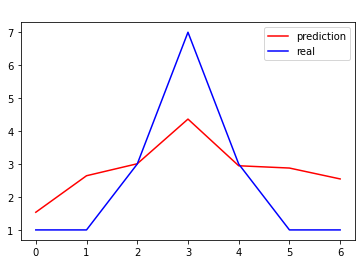

In [15]:
# 打印评判标准
metrics(y_test, yhat)

# 可视化作图
plt.title(' ')
plt.plot(yhat, 'r', label='prediction')
plt.plot(y_test, 'b', label='real')

plt.legend(loc='best')
plt.savefig('emd.png')
plt.show()